In [1]:
import sys
print(sys.version)




3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]


In [2]:
"""Random Dilated Shapelet Transform (RDST) Classifier.

A Random Dilated Shapelet Transform classifier pipeline that simply performs a random
shapelet dilated transform and builds (by default) a ridge classifier on the output.
"""

__maintainer__ = ["baraline"]
__all__ = ["RDSTClassifier"]

from typing import Union

import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from typing import Union, List, Dict
from aeon.base._base import _clone_estimator
from aeon.classification.base import BaseClassifier
from aeon.transformations.collection.shapelet_based import (
    RandomDilatedShapeletTransform,
)


class RDSTClassifier(BaseClassifier):
    """
    A random dilated shapelet transform (RDST) classifier.

    Implementation of the random dilated shapelet transform classifier pipeline
    along the lines of [1]_, [2]_. Transforms the data using the
    `RandomDilatedShapeletTransform` and then builds a `RidgeClassifierCV` classifier
    with standard scaling.

    Parameters
    ----------
    max_shapelets : int, default=10000
        The maximum number of shapelets to keep for the final transformation.
        A lower number of shapelets can be kept if alpha similarity has discarded the
        whole dataset.
    shapelet_lengths : array, default=None
        The set of possible lengths for shapelets. Each shapelet length is uniformly
        drawn from this set. If None, the shapelet length will be equal to
        min(max(2,n_timepoints//2),11).
    proba_normalization : float, default=0.8
        This probability (between 0 and 1) indicates the chance of each shapelet to be
        initialized such as it will use a z-normalized distance, inducing either scale
        sensitivity or invariance. A value of 1 would mean that all shapelets will use
        a z-normalized distance.
    threshold_percentiles : array, default=None
        The two perceniles used to select the threshold used to compute the Shapelet
        Occurrence feature. If None, the 5th and the 10th percentiles (i.e. [5,10])
        will be used.
    alpha_similarity : float, default=0.5
        The strength of the alpha similarity pruning. The higher the value, the fewer
        common indexes with previously sampled shapelets are allowed when sampling a
        new candidate with the same dilation parameter. It can cause the number of
        sampled shapelets to be lower than max_shapelets if the whole search space has
        been covered. The default is 0.5, and the maximum is 1. Values above it have
        no effect for now.
    use_prime_dilations : bool, default=False
        If True, restricts the value of the shapelet dilation parameter to be prime
        values. This can greatly speed-up the algorithm for long time series and/or
        short shapelet lengths, possibly at the cost of some accuracy.
    estimator : BaseEstimator or None, default=None
        Base estimator for the ensemble, can be supplied a sklearn `BaseEstimator`. If
        `None` a default `RidgeClassifierCV` classifier is used with standard scaling.
    save_transformed_data : bool, default=False
        If True, the transformed training dataset for all classifiers will be saved.
    class_weight{“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
        Only applies if estimator is None, and the default is used.
        From sklearn documentation:
        If not given, all classes are supposed to have weight one.
        The “balanced” mode uses the values of y to automatically adjust weights
        inversely proportional to class frequencies in the input data as
        n_samples / (n_classes * np.bincount(y))
        The “balanced_subsample” mode is the same as “balanced” except that weights
        are computed based on the bootstrap sample for every tree grown.
        For multi-output, the weights of each column of y will be multiplied.
        Note that these weights will be multiplied with sample_weight (passed through
        the fit method) if sample_weight is specified.
    n_jobs : int, default=1
        The number of jobs to run in parallel for both ``fit`` and ``predict``.
        `-1` means using all processors.
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.

    Attributes
    ----------
    classes_ : list
        The unique class labels in the training set.
    n_classes_ : int
        The number of unique classes in the training set.
    transformed_data_ : list of shape (n_estimators) of ndarray
        The transformed training dataset for all classifiers. Only saved when
        ``save_transformed_data`` is `True`.

    See Also
    --------
    RandomDilatedShapeletTransform : The randomly dilated shapelet transform.
    RidgeClassifierCV : The default classifier used.

    References
    ----------
    .. [1] Antoine Guillaume et al. "Random Dilated Shapelet Transform: A New Approach
       for Time Series Shapelets", Pattern Recognition and Artificial Intelligence.
       ICPRAI 2022.
    .. [2] Antoine Guillaume, "Time series classification with shapelets: Application
       to predictive maintenance on event logs", PhD Thesis, University of Orléans,
       2023.


    Examples
    --------
    >>> from aeon.classification.shapelet_based import RDSTClassifier
    >>> from aeon.datasets import load_unit_test
    >>> X_train, y_train = load_unit_test(split="train")
    >>> X_test, y_test = load_unit_test(split="test")
    >>> clf = RDSTClassifier(
    ...     max_shapelets=10
    ... )
    >>> clf.fit(X_train, y_train)
    RDSTClassifier(...)
    >>> y_pred = clf.predict(X_test)
    """

    _tags = {
        "capability:multivariate": True,
        "capability:unequal_length": True,
        "capability:multithreading": True,
        "X_inner_type": ["np-list", "numpy3D"],
        "algorithm_type": "shapelet",
    }

    def __init__(
        self,
        max_shapelets: int = 50000,
        shapelet_lengths=None,
        proba_normalization: float = 0.8,
        threshold_percentiles=None,
        alpha_similarity: float = 0.5,
        use_prime_dilations: bool = False,
        estimator=None,
        save_transformed_data: bool = False,
        class_weight=None,
        n_jobs: int = 1,
        random_state: Union[int, np.random.RandomState, None] = None,
    ) -> None:
        self.max_shapelets = max_shapelets
        self.shapelet_lengths = shapelet_lengths
        self.proba_normalization = proba_normalization
        self.threshold_percentiles = threshold_percentiles
        self.alpha_similarity = alpha_similarity
        self.use_prime_dilations = use_prime_dilations
        self.estimator = estimator
        self.save_transformed_data = save_transformed_data
        self.class_weight = class_weight
        self.random_state = random_state
        self.n_jobs = n_jobs

        self.transformed_data_ = []

        self._transformer = None
        self._estimator = None

        super().__init__()

    def _fit(self, X, y):
        """Fit Classifier to training data.

        Parameters
        ----------
        X: np.ndarray shape (n_cases, n_channels, n_timepoints)
            The training input samples.
        y: array-like or list
            The class labels for samples in X.

        Returns
        -------
        self :
            Reference to self.

        Notes
        -----
        Changes state by creating a fitted model that updates attributes
        ending in "_".
        """
        self._transformer = RandomDilatedShapeletTransform(
            max_shapelets=self.max_shapelets,
            shapelet_lengths=self.shapelet_lengths,
            proba_normalization=self.proba_normalization,
            threshold_percentiles=self.threshold_percentiles,
            alpha_similarity=self.alpha_similarity,
            use_prime_dilations=self.use_prime_dilations,
            n_jobs=self.n_jobs,
            random_state=self.random_state,
        )
        if self.estimator is None:
            self._estimator = make_pipeline(
                StandardScaler(with_mean=True),
                RidgeClassifierCV(
                    alphas=np.logspace(-4, 4, 20),
                    class_weight=self.class_weight,
                ),
            )
        else:
            self._estimator = _clone_estimator(self.estimator, self.random_state)
            m = getattr(self._estimator, "n_jobs", None)
 
            if m is not None:
                self._estimator.n_jobs = self.n_jobs

        X_t = self._transformer.fit_transform(X, y)

        if self.save_transformed_data:
            self.transformed_data_ = X_t

        self._estimator.fit(X_t, y)

        return self

    def _predict(self, X) -> np.ndarray:
        """Predicts labels for sequences in X.

        Parameters
        ----------
        X: np.ndarray shape (n_cases, n_channels, n_timepoints)
            The data to make predictions for.

        Returns
        -------
        y : array-like, shape = [n_cases]
            Predicted class labels.
        """
        X_t = self._transformer.transform(X)

        return self._estimator.predict(X_t)

    def _predict_proba(self, X) -> np.ndarray:
        """Predicts label probabilities for sequences in X.

        Parameters
        ----------
        X: np.ndarray shape (n_cases, n_channels, n_timepoints)
            The data to predict probabilities for.

        Returns
        -------
        y : array-like, shape = [n_cases, n_classes_]
            Predicted probabilities using the ordering in classes_.
        """
        X_t = self._transformer.transform(X)

        m = getattr(self._estimator, "predict_proba", None)
        if callable(m):
            return self._estimator.predict_proba(X_t)
        else:
            dists = np.zeros((len(X), self.n_classes_))
            preds = self._estimator.predict(X_t)
            for i in range(0, len(X)):
                dists[i, np.where(self.classes_ == preds[i])] = 1
            return dists

    def _get_test_params(
        cls, parameter_set: str = "default"
    ) -> Union[Dict, List[Dict]]:
        """Return testing parameter settings for the estimator.

        Parameters
        ----------
        parameter_set : str, default="default"
            Name of the set of test parameters to return, for use in tests. If no
            special parameters are defined for a value, will return `"default"` set.
            For classifiers, a "default" set of parameters should be provided for
            general testing, and a "results_comparison" set for comparing against
            previously recorded results if the general set does not produce suitable
            probabilities to compare against.

        Returns
        -------
        params : dict or list of dict, default={}
            Parameters to create testing instances of the class.
            Each dict are parameters to construct an "interesting" test instance, i.e.,
            `MyClass(**params)` or `MyClass(**params[i])` creates a valid test instance.
        """
        return {"max_shapelets": 20}

In [3]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from aeon.datasets import load_unit_test
from sklearn.metrics import accuracy_score

class RDSTClassifierWithPCS(RDSTClassifier):
    """
    RocketClassifier extended to include Principal Component Selection (PCS)
    using PCA on the feature matrix before classification.
    """
    def __init__(
        self,
        max_shapelets: int = 50000,
        n_pcs: int = 20000,  # Set default number of principal components to keep
        shapelet_lengths=None,
        proba_normalization: float = 0.8,
        threshold_percentiles=None,
        alpha_similarity: float = 0.5,
        use_prime_dilations: bool = False,
        estimator=None,
        save_transformed_data: bool = False,
        class_weight=None,
        n_jobs: int = 1,
        random_state: Union[int, np.random.RandomState, None] = None,
       ):
        self.n_pcs = n_pcs
        # Initialize the parent class (RDSTClassifier)
        super().__init__(
            max_shapelets=max_shapelets,
            shapelet_lengths=shapelet_lengths,
            proba_normalization=proba_normalization,
            threshold_percentiles=threshold_percentiles,
            alpha_similarity=alpha_similarity,
            use_prime_dilations=use_prime_dilations,
            estimator=estimator,
            save_transformed_data=save_transformed_data,
            class_weight=class_weight,
            n_jobs=n_jobs,
            random_state=random_state,
        )
    
    def _fit(self, X, y):
        """Fit Rocket variant and PCA to the training data."""
        super()._fit(X, y)  # Call the original RocketClassifier's fit method

        # Apply PCA if n_pcs is specified
        if self.n_pcs is not None:
            self._pca = PCA(n_components=self.n_pcs, random_state=self.random_state)
        else:
            self._pca = PCA(random_state=self.random_state)

        # Transform the Rocket features with PCA

        # [changed] Not require to perform this as this step is involed in self.pipeline_.fit(X, y)
        # rocket_features = self._transformer.transform(X)
        # self._pca.fit(rocket_features)
        # pca_features = self._pca.transform(rocket_features)

        # Update the pipeline to include PCA
        self.pipeline_ = make_pipeline(
            self._transformer,
            #self._scaler,
            self._pca,
            self._estimator,
        )

        # [changed] pca_features to X
        self.pipeline_.fit(X, y)

        return self
    
    def _predict(self, X):
        """Predict labels for sequences in X after PCA transformation."""
        # [changed] no need apply them explicitly
        # rocket_features = self._transformer.transform(X)
        # pca_features = self._pca.transform(rocket_features)
        return self.pipeline_.predict(X)

    def _predict_proba(self, X):
        """Predict probabilities for sequences in X after PCA transformation."""
        # [changed]
        # rocket_features = self._transformer.transform(X)
        # pca_features = self._pca.transform(rocket_features)
        return self.pipeline_.predict_proba(X)





In [4]:
import random

import numpy as np
import torch
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.backends.cudnn.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.fftpack import dct  # Import DCT from scipy
import librosa  # Ensure librosa is imported for loading audio files

# Custom Dataset Class
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

def pre_emphasis(signal, alpha=0.97):
    """Apply pre-emphasis filter."""
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

def framing(signal, frame_size, hop_size):
    """Split signal into overlapping frames."""
    num_frames = int(np.ceil(float(np.abs(len(signal) - frame_size)) / hop_size)) + 1
    pad_signal_length = num_frames * hop_size + frame_size
    z = np.zeros(pad_signal_length)
    z[:len(signal)] = signal
    
    frames = np.lib.stride_tricks.as_strided(z,
        shape=(num_frames, frame_size),
        strides=(z.strides[0] * hop_size, z.strides[0])).copy()
    
    return frames

def hamming_window(frame):
    """Apply Hamming window to a frame."""
    return np.hamming(len(frame)) * frame

def mel_filter_bank(num_filters, fft_size, sample_rate, low_freq=0, high_freq=None):
    """Create a Mel filter bank."""
    if high_freq is None:
        high_freq = sample_rate / 2
    
    # Convert frequency to Mel scale
    low_mel = 2595 * np.log10(1 + low_freq / 700)
    high_mel = 2595 * np.log10(1 + high_freq / 700)
    
    mel_points = np.linspace(low_mel, high_mel, num_filters + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)
    
    filters = np.zeros((num_filters, int(np.floor(fft_size / 2 + 1))))
    
    for n in range(1, num_filters + 1):
        filters[n - 1, bin_points[n - 1]:bin_points[n]] = \
            (np.arange(bin_points[n - 1], bin_points[n]) - bin_points[n - 1]) / (bin_points[n] - bin_points[n - 1])
        filters[n - 1, bin_points[n]:bin_points[n + 1]] = \
            (bin_points[n + 1] - np.arange(bin_points[n], bin_points[n + 1])) / (bin_points[n + 1] - bin_points[n])
    
    return filters

def compute_mfcc(signal, sample_rate=16000, n_mfcc=13, n_fft=400, hop_length=160):
    """Compute MFCC from scratch."""
    # Step 1: Pre-emphasis
    emphasized_signal = pre_emphasis(signal)

    # Step 2: Framing
    frames = framing(emphasized_signal, n_fft, hop_length)

    # Step 3: Apply Hamming window
    windowed_frames = np.array([hamming_window(frame) for frame in frames])

    # Step 4: FFT and Power Spectrum
    mag_frames = np.abs(np.fft.rfft(windowed_frames, n=n_fft)) ** 2

    # Step 5: Mel Filter Bank
    mel_filters = mel_filter_bank(n_mfcc, n_fft, sample_rate)
    
    # Step 6: Apply Mel filter bank to power spectrum
    mel_energies = np.dot(mag_frames, mel_filters.T)

    # Step 7: Logarithm of Mel energies
    log_mel_energies = np.log(mel_energies + np.finfo(float).eps)

    # Step 8: Discrete Cosine Transform (DCT)
    mfccs = dct(log_mel_energies, type=2, axis=1, norm='ortho')[:, :n_mfcc]

    return mfccs

def load_data_with_mfcc(directory, n_mfcc=13, n_fft=400, hop_size=160, target_length=16000):
    """Load data from a directory and extract MFCC features."""
    X = []
    y = []
    labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_dir, file_name)
                    signal, rate = librosa.load(file_path, sr=None)  # Load audio to get its length
                    
                    # Check if the audio signal length is less than the target length (16000 samples)
                    if len(signal) < target_length:
                        # Pad the signal to 16000 samples if it's too short
                        padding = target_length - len(signal)
                        signal = np.pad(signal, (0, padding), 'constant')

                    # Check if the audio length is greater than the target length (16000 samples)
                    if len(signal) > target_length:
                        # Truncate the signal to 16000 samples if it's too long
                        signal = signal[:target_length]

                    audio_length = len(signal)  # Length in samples
                    mfcc = compute_mfcc(signal, sample_rate=rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_size)
                    num_frames = mfcc.shape[1]

                    # Check if the first window is less than 25 ms (400 samples)
                    if num_frames > 0 and (num_frames * hop_size < 400):  
                        print(f"Stopping processing for {file_name}: first window is less than 30 ms.")
                        break
                    
                    X.append(mfcc)
                    y.append(label_map[label])
                    
                    # Display number of frames and audio length for each sample
                    #print(f"File: {file_name}, Label: {label}, Audio Length: {audio_length} samples, Number of frames: {num_frames}")

                    # Print total number of windows for each file
                    #print(f"Total number of windows for {file_name}: {num_frames}")

                    # Print shape of the feature vector (MFCC matrix)
                    #print(f"MFCC feature vector shape for {file_name}: {mfcc.shape}")

            else:
                continue  
            break  

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print("Feature array shape:", X.shape)  
    print("Labels array shape:", y.shape)

    return X, y, labels


# Section 3: Data Loading and Preprocessing
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/12KWS"
X, y, labels = load_data_with_mfcc(directory)

# Reshape X for CNN input (add channel dimension if needed)
if X.size > 0:
   X = X[:, :, :]  




Feature array shape: (27692, 99, 13)
Labels array shape: (27692,)


In [6]:
# Reshape X for CNN input (swap dimensions 1 and 2)
if X.size > 0:
   X = X.transpose(0, 2, 1)  # Change shape from (23682, 50, 13) to (23682, 13, 50)
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# You can add your model training and evaluation code here.

In [7]:
print(X.shape)

(27692, 13, 99)


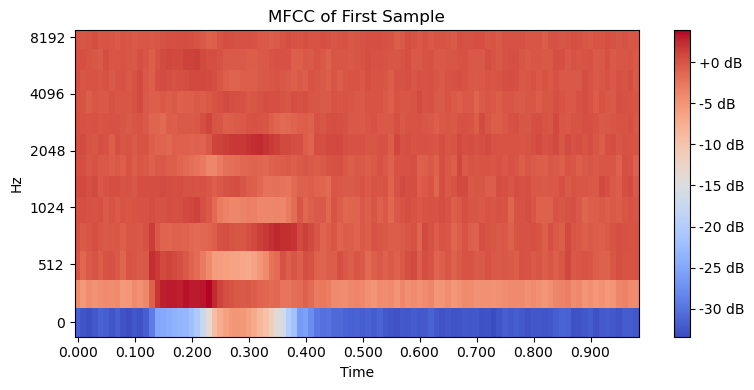

In [8]:
import matplotlib.pyplot as plt
import librosa.display

# Assuming your spectrogram matrix is named 'spectrogram'
first_sample = X_train[0]  # Shape: (13, 99)

plt.figure(figsize=(8, 4))
librosa.display.specshow(first_sample, 
                         x_axis='time', 
                         y_axis='mel', 
                         sr=16000,  # Adjust this to your actual sample rate
                         hop_length=160)  # Adjust this to your actual hop length
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC of First Sample')
plt.tight_layout()
plt.show()


In [9]:
print(X_train.shape)

(22153, 13, 99)


In [10]:
clf = RDSTClassifierWithPCS(random_state=42,max_shapelets=50000,n_pcs=10000)

In [11]:
# Fit the classifier on the training data
clf.fit(X_train, y_train)

RDSTClassifierWithPCS(n_pcs=10000, random_state=42)

In [12]:
param = clf._estimator.steps[-1][1]  

# Counting the number of parameters (coef_ and intercept_)
n_params = param.coef_.size + param.intercept_.size
print(f"Number of parameters: {n_params}")

Number of parameters: 120012


In [13]:
# Predict on the test set
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.9332009387976169


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score for each class (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")





Precision (macro): 0.9351306160356364
Recall (macro): 0.9333110382960207
F1 Score (macro): 0.9336037081379609


In [15]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = clf.predict(X_test)

# Print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       445
           1       0.89      0.93      0.91       486
           2       0.96      0.95      0.95       479
           3       0.90      0.92      0.91       510
           4       0.89      0.93      0.91       473
           5       0.94      0.95      0.94       491
           6       0.98      0.97      0.98       465
           7       0.99      1.00      0.99       383
           8       0.96      0.95      0.96       445
           9       0.93      0.78      0.85       427
          10       0.89      0.92      0.90       480
          11       0.97      0.97      0.97       455

    accuracy                           0.93      5539
   macro avg       0.94      0.93      0.93      5539
weighted avg       0.93      0.93      0.93      5539



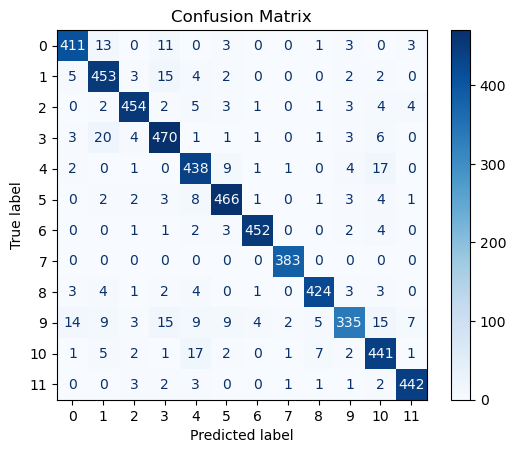

In [16]:
#confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()




In [17]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=labels))
# Map for labels
print("Label mapping:", {idx: label for label, idx in enumerate(labels)})

Classification Report:
               precision    recall  f1-score   support

        down       0.94      0.92      0.93       445
          go       0.89      0.93      0.91       486
        left       0.96      0.95      0.95       479
          no       0.90      0.92      0.91       510
         off       0.89      0.93      0.91       473
          on       0.94      0.95      0.94       491
       right       0.98      0.97      0.98       465
     silence       0.99      1.00      0.99       383
        stop       0.96      0.95      0.96       445
     unknown       0.93      0.78      0.85       427
          up       0.89      0.92      0.90       480
         yes       0.97      0.97      0.97       455

    accuracy                           0.93      5539
   macro avg       0.94      0.93      0.93      5539
weighted avg       0.93      0.93      0.93      5539

Label mapping: {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'silence': 7, 'stop': 

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Get the probabilities for each class
y_scores = clf.predict_proba(X_test)  # Shape: (n_samples, n_classes)

# Number of classes
n_classes = y_scores.shape[1]

# Plot Precision-Recall curves for each class
plt.figure(figsize=(10, 8))
for class_idx in range(n_classes):
    # Binarize the true labels for the current class (one-vs-rest)
    y_true_binary = (y_test == class_idx).astype(int)
    
    # Get probabilities for the current class
    y_scores_class = y_scores[:, class_idx]
    
    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_true_binary, y_scores_class)
    
    # Calculate AUC
    auc_score = auc(recall, precision)
    
    # Plot the curve
    plt.plot(recall, precision, label=f'Class {class_idx} (AUC = {auc_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend()
plt.show()


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Binarize labels for multiclass (e.g., classes 0, 1, 2)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8,9,10,11])
y_scores_binarized = clf.predict_proba(X_test)

# Compute micro-averaged precision-recall
precision, recall, _ = precision_recall_curve(
    y_test_binarized.ravel(), y_scores_binarized.ravel()
)

# Calculate micro-averaged AUC
auc_score = auc(recall, precision)

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Micro-Averaged (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Averaged Precision-Recall Curve')
plt.legend()
plt.show()


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    PrecisionRecallDisplay,
)
import numpy as np
import matplotlib.pyplot as plt

y_scores = clf.predict_proba(X_test) 
# Assuming Y_test has shape (n_samples,) with labels 0, 1, ..., n_classes-1
# One-hot encode Y_test
n_classes = len(np.unique(y_test))
encoder = OneHotEncoder(sparse=False)
Y_test_one_hot = encoder.fit_transform(y_test.reshape(-1, 1))  # Shape: (n_samples, n_classes)

# Assuming y_score has shape (n_samples, n_classes) with predicted probabilities
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test_one_hot[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(Y_test_one_hot[:, i], y_scores[:, i])

# Micro-average: Evaluate all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test_one_hot.ravel(), y_scores.ravel()
)
average_precision["micro"] = average_precision_score(Y_test_one_hot, y_scores, average="micro")

# Visualize the micro-averaged Precision-Recall curve
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)

# Plot
display.plot(plot_chance_level=True)
display.ax_.set_title("Micro-Averaged Precision-Recall Curve")
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

# Number of classes
n_classes = 12
from sklearn.preprocessing import label_binarize
Y_test = label_binarize(y_test, classes=np.arange(n_classes))
y_score = clf.predict_proba(X_test)

# Assuming Y_test is one-hot encoded (or use label_binarize to encode if it's not)
# Example: Y_test = label_binarize(Y_test, classes=np.arange(n_classes))

# Calculate precision, recall, and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# Micro-average: Quantifying the score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

# Setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

# Plot iso-F1 curves
f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = ax.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    ax.annotate(f"f1={f_score:0.1f}", xy=(0.9, y[45] + 0.02))

# Plot the micro-average precision-recall curve
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

# Plot the precision-recall curve for each class
for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# Add the legend for the iso-F1 curves
handles, labels = ax.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()


## Output for single/few input

In [ ]:
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/testfile"
X_sample, y_sample, labels = load_data_with_mfcc(directory)
if X_sample.size > 0:
   X_sample = X_sample.transpose(0, 2, 1) 

print(X_sample.shape)

In [ ]:
y_pred_test_sample = clf.predict(X_sample)

#Display the predicted class
print("Predicted class for the new sample:", y_pred_test_sample)

## Visualisation of shapelets

In [ ]:
#from aeon.visualisation import ShapeletTransformerVisualizer

st_vis = ShapeletTransformerVisualizer(clf)
id_shapelet = 0  # Identifier of the shapelet

fig = st_vis.plot_on_X(id_shapelet, X_test[1], figure_options={"figsize": (7, 4)})

In [ ]:

#from aeon.visualisation import ShapeletClassifierVisualizer

stc_vis = ShapeletClassifierVisualizer(clf)
id_class = 0
fig = stc_vis.visualize_shapelets_one_class(
    X_test,
    y_test,
    id_class,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

In [ ]:
"""Shapelet plotting tools."""

__maintainer__ = ["baraline"]

__all__ = ["ShapeletClassifierVisualizer", "ShapeletTransformerVisualizer"]

import copy
import warnings

import numpy as np
from numba import njit
from sklearn.ensemble._forest import BaseForest
from sklearn.linear_model._base import LinearClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import BaseDecisionTree

from aeon.classification.shapelet_based import (
    RDSTClassifier,
    RSASTClassifier,
    SASTClassifier,
    ShapeletTransformClassifier,
)
from aeon.transformations.collection.shapelet_based import (
    RSAST,
    SAST,
    RandomDilatedShapeletTransform,
    RandomShapeletTransform,
)
#from aeon.transformations.collection.shapelet_based._dilated_shapelet_transform import (
#    get_all_subsequences,
#    normalise_subsequences,
#)
from aeon.utils.numba.general import sliding_mean_std_one_series
from aeon.utils.validation._dependencies import _check_soft_dependencies


@njit(fastmath=True, cache=True)
def compute_shapelet_dist_vector(
    X_subs: np.ndarray,
    values: np.ndarray,
):
    """Extract the features from a shapelet distance vector.

    Given a shapelet and a time series, extract three features from the resulting
    distance vector:
        - min
        - argmin
        - Shapelet Occurence : number of point in the distance vector inferior to the
        threshold parameter

    Parameters
    ----------
    X_subs : array, shape (n_timestamps-(length-1)*dilation, n_channels, length)
        The subsequences of an input time series given the length and dilation parameter
    values : array, shape (n_channels, length)
        The value array of the shapelet
    length : int
        Length of the shapelet
    distance: CPUDispatcher
        A Numba function used to compute the distance between two multidimensional
        time series of shape (n_channels, length).

    Returns
    -------
    dist_vector : array, shape = (n_timestamps-(length-1)*dilation)
        The distance vector between the shapelets and candidate subsequences using
        the Euclidean distance.
    """
    n_subsequences, n_channels, length = X_subs.shape
    dist_vector = np.zeros(n_subsequences)
    for i_sub in range(n_subsequences):
        dist_vector[i_sub] += (((X_subs[i_sub] - values) ** 2).sum()) ** 0.5
    return dist_vector


class ShapeletVisualizer:
    """
    A Shapelet object to use for ploting operations.

    Parameters
    ----------
    values : array, shape=(n_channels, length)
        Values of the shapelet.
    normalise : bool
        Wheter the shapelet use a normalised distance.
    dilation : int
        Dilation of the shapelet. The default is 1, which is equivalent to no
        dilation.
    threshold : float
        Lambda threshold for Shapelet Occurrence feature. The default value is None
        if it is not used (used in RDST).
    length : int
        Length of the shapelet. The default values is None, meaning length is infered
        from the values array. Otherwise, the values array 2nd axis will be set to this
        length.

    """

    def __init__(
        self,
        values,
        normalise=False,
        dilation=1,
        threshold=None,
        length=None,
    ):
        self.values = np.asarray(values)
        if self.values.ndim == 1:
            self.values = self.values[np.newaxis, :]
        if length is None:
            self.length = self.values.shape[1]
        else:
            self.values = self.values[:, :length]
            self.length = length
        self.n_channels = self.values.shape[0]
        self.normalise = normalise
        self.threshold = threshold
        self.dilation = dilation

    def plot(
        self,
        ax=None,
        scatter_options={  # noqa: B006
            "s": 70,
            "alpha": 0.75,
            "zorder": 3,
            "edgecolor": "black",
            "linewidths": 2,
        },
        line_options={  # noqa: B006
            "linewidth": 2,
            "alpha": 0.9,
            "linestyle": "--",
        },
        figure_options={  # noqa: B006
            "figsize": (10, 5),
            "dpi": 100,
        },
        rc_Params_options={"font.size": 22},  # noqa: B006
        matplotlib_style="seaborn-v0_8",
        custom_title_string=None,
    ):
        """
        Plot the shapelet values.

        Parameters
        ----------
        ax : matplotlib axe
            A matplotlib axe on which to plot the figure. The default is None
            and will create a new figure of size figsize.
        line_options : dict
            Options to apply to plot of the shapelet values.
        scatter_options : dict
            Options to apply to scatter plot of the shapelet values.
        figure_options : dict
            Dictionnary of options passed to plt.figure. Only used if ax is None.
        rc_Params_options: dict
            Dictionnary of options passed to plt.rcParams.update. Only used if ax is
            None.
        matplotlib_style: str
            Matplotlib style to be used. Only used if ax is None.
        custom_title_string : str
            If not None, use this string as title for the plot instead of the default
            one based on the shapelet parametres.

        Returns
        -------
        fig : matplotlib figure
            The resulting figure
        """
        _check_soft_dependencies("matplotlib")
        import matplotlib.pyplot as plt

        if "label" not in line_options.keys():
            line_options["label"] = ""
        if custom_title_string is None:
            title_string = "Shapelet params:"
            if self.dilation > 1:
                title_string += f" dilation={self.dilation}"
            if self.threshold is not None:
                title_string += f" threshold={np.round(self.threshold, decimals=2)}"
            title_string += f" normalise={self.normalise}"
        else:
            title_string = custom_title_string
        if ax is None:
            plt.style.use(matplotlib_style)
            plt.rcParams.update(rc_Params_options)

            fig = plt.figure(**figure_options)
            for i in range(self.n_channels):
                if self.n_channels > 1:
                    line_options.update(
                        {"label": str(line_options["label"]) + f" channel {i}"}
                    )
                plt.plot(self.values[i], **line_options)
                plt.scatter(np.arange(self.length), self.values[i], **scatter_options)
            plt.ylabel("shapelet values")
            plt.xlabel("timepoint")
            plt.title(title_string)
            if self.n_channels > 1:
                plt.legend()
            return fig
        else:
            for i in range(self.n_channels):
                if self.n_channels > 1:
                    line_options.update(
                        {"label": str(line_options["label"]) + f" channel {i}"}
                    )
                ax.plot(self.values[i], **line_options)
                ax.scatter(np.arange(self.length), self.values[i], **scatter_options)
            ax.set_title(title_string)
            ax.set_ylabel("shapelet values")
            ax.set_xlabel("timepoint")
            if self.n_channels > 1:
                ax.legend()
            return ax

    def plot_on_X(
        self,
        X,
        ax=None,
        scatter_options={  # noqa: B006
            "s": 40,
            "c": "purple",
            "alpha": 0.75,
            "zorder": 1,
        },
        line_options={"linewidth": 2, "alpha": 0.9},  # noqa: B006
        figure_options={  # noqa: B006
            "figsize": (10, 5),
            "dpi": 100,
        },
        rc_Params_options={"font.size": 22},  # noqa: B006
        matplotlib_style="seaborn-v0_8",
    ):
        """
        Plot the shapelet on its best match on the time series X.

        Parameters
        ----------
        X : array, shape=(n_features, n_timestamps)
            Input time series
        ax : matplotlib axe
            A matplotlib axe on which to plot the figure. The default is None
            and will create a new figure of size figsize.
        scatter_options : dict
            Dictionnary of options passed to the scatter plot of the shapelet values.
        line_options : dict
            Dictionnary of options passed to the plot of the time series values.
        figure_options : dict
            Dictionnary of options passed to plt.figure. Only used if ax is None.
        rc_Params_options: dict
            Dictionnary of options passed to plt.rcParams.update. Only used if ax is
            None.
        matplotlib_style: str
            Matplotlib style to be used. Only used if ax is None.

        Returns
        -------
        fig : matplotlib figure
            The resulting figure with S on its best match on X. A normalised
            shapelet will be scalled to macth the scale of X.

        """
        _check_soft_dependencies("matplotlib")
        import matplotlib.pyplot as plt

        if len(X.shape) == 1:
            X = X[np.newaxis, :]

        if "label" not in line_options.keys():
            line_options["label"] = ""

        # Get candidate subsequences in X
        X_subs = get_all_subsequences(X, self.length, self.dilation)

        # normalise candidates and shapelet values
        if self.normalise:
            X_means, X_stds = sliding_mean_std_one_series(X, self.length, self.dilation)
            X_subs = normalise_subsequences(X_subs, X_means, X_stds)
            _values = (
                self.values - self.values.mean(axis=-1, keepdims=True)
            ) / self.values.std(axis=-1, keepdims=True)
        else:
            _values = self.values

        # Compute distance vector
        c = compute_shapelet_dist_vector(X_subs, _values)

        # Get best match index
        idx_best = c.argmin()
        idx_match = np.asarray(
            [(idx_best + i * self.dilation) % X.shape[1] for i in range(self.length)]
        ).astype(int)

        # If normalise, scale back the values of the shapelet to the scale of the match
        if self.normalise:
            _values = (_values * X[:, idx_match].std(axis=-1, keepdims=True)) + X[
                :, idx_match
            ].mean(axis=-1, keepdims=True)

        if ax is None:
            plt.style.use(matplotlib_style)
            plt.rcParams.update(rc_Params_options)

            fig = plt.figure(**figure_options)
            for i in range(self.n_channels):
                if self.n_channels > 1:
                    line_options.update(
                        {"label": str(line_options["label"]) + f" channel {i}"}
                    )
                plt.plot(X[i], **line_options)
                plt.scatter(idx_match, _values[i], **scatter_options)
                plt.title("Best match of shapelet on X")
            plt.ylabel("shapelet values")
            plt.xlabel("timepoint")
            return fig
        else:
            for i in range(self.n_channels):
                if self.n_channels > 1:
                    line_options.update(
                        {"label": str(line_options["label"]) + f" channel {i}"}
                    )
                ax.plot(X[i], **line_options)
                ax.scatter(idx_match, _values[i], **scatter_options)
            ax.set_ylabel("shapelet values")
            ax.set_xlabel("timepoint")
            return ax

    def plot_distance_vector(
        self,
        X,
        ax=None,
        show_legend=True,
        show_threshold=True,
        line_options={"linewidth": 2, "alpha": 0.9},  # noqa: B006
        threshold_options={  # noqa: B006
            "linewidth": 2,
            "alpha": 0.9,
            "color": "purple",
            "label": "threshold",
        },
        figure_options={  # noqa: B006
            "figsize": (10, 5),
            "dpi": 100,
        },
        rc_Params_options={"font.size": 22},  # noqa: B006
        matplotlib_style="seaborn-v0_8",
    ):
        """
        Plot the shapelet distance vector computed between itself and X.

        Parameters
        ----------
        X : array, shape=(n_features, n_timestamps)
            Input time series
        ax : matplotlib axe
            A matplotlib axe on which to plot the figure. The default is None
            and will create a new figure of size figsize.
        show_legend : bool, optional
            Wheter to show legend. Default is True
        show_threshold: bool, optional
            Wheter to show threshold (if it is not set to None). Default is True.
        threshold_options : dict
            Dictionnary of options passed to the line plot of the threshold.
        line_options : dict
            Dictionnary of options passed to the plot of the distance vector values.
        figure_options : dict
            Dictionnary of options passed to plt.figure. Only used if ax is None.
        rc_Params_options: dict
            Dictionnary of options passed to plt.rcParams.update. Only used if ax is
            None.
        matplotlib_style: str
            Matplotlib style to be used. Only used if ax is None.

        Returns
        -------
        fig : matplotlib figure
            The resulting figure with the distance vector obtained by d(S,X)

        """
        _check_soft_dependencies("matplotlib")
        import matplotlib.pyplot as plt

        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        # Get candidate subsequences in X
        X_subs = get_all_subsequences(X, self.length, self.dilation)
        # normalise candidates and shapelet values
        if self.normalise:
            X_means, X_stds = sliding_mean_std_one_series(X, self.length, self.dilation)
            X_subs = normalise_subsequences(X_subs, X_means, X_stds)
            _values = (self.values - self.values.mean(axis=-1)) / self.values.std(
                axis=1
            )
        else:
            _values = self.values
        c = compute_shapelet_dist_vector(X_subs, _values)

        if ax is None:
            plt.style.use(matplotlib_style)
            plt.rcParams.update(rc_Params_options)
            fig = plt.figure(**figure_options)

            plt.plot(c, **line_options)
            if self.threshold is not None and show_threshold:
                plt.hlines(self.threshold, 0, c.shape[0], **threshold_options)
            plt.title("Distance vector between shapelet and X")
            if show_legend and self.n_channels > 1:
                plt.legend()
            return fig
        else:
            ax.plot(c, **line_options)
            if self.threshold is not None and show_threshold:
                ax.hlines(self.threshold, 0, c.shape[0], **threshold_options)
            return ax


class ShapeletTransformerVisualizer:
    """
    A class to visualize the result from a fitted shapelet transformer.

    Parameters
    ----------
    estimator : object
        A fitted shapelet transformer.

    """

    def __init__(self, estimator):
        self.estimator = estimator

    def _get_shapelet(self, id_shapelet):
        if isinstance(self.estimator, RandomDilatedShapeletTransform):
            values_ = self.estimator.shapelets_[0][id_shapelet]
            # startpos_ = self.estimator.shapelets_[1][id_shapelet]
            length_ = self.estimator.shapelets_[2][id_shapelet]
            dilation_ = self.estimator.shapelets_[3][id_shapelet]
            threshold_ = self.estimator.shapelets_[4][id_shapelet]
            normalise_ = self.estimator.shapelets_[5][id_shapelet]

        elif isinstance(self.estimator, (RSAST, SAST)):
            values_ = self.estimator._kernel_orig[id_shapelet]
            length_ = values_.shape[0]
            dilation_ = 1
            normalise_ = True
            threshold_ = None

        elif isinstance(self.estimator, RandomShapeletTransform):
            values_ = self.estimator.shapelets[id_shapelet][6]
            length_ = self.estimator.shapelets[id_shapelet][1]
            dilation_ = 1
            normalise_ = True
            threshold_ = None
        else:
            raise NotImplementedError(
                "The provided estimator of type {type(self.estimator)} is not supported"
                ". Is it a shapelet transformer ?"
            )
        return ShapeletVisualizer(
            values_,
            normalise=normalise_,
            dilation=dilation_,
            threshold=threshold_,
            length=length_,
        )

    def plot_on_X(
        self,
        id_shapelet,
        X,
        ax=None,
        scatter_options={  # noqa: B006
            "s": 40,
            "c": "purple",
            "alpha": 0.9,
            "zorder": 3,
        },
        line_options={"linewidth": 2, "alpha": 0.9},  # noqa: B006
        figure_options={  # noqa: B006
            "figsize": (10, 5),
            "dpi": 100,
        },
        rc_Params_options={"font.size": 22},  # noqa: B006
        matplotlib_style="seaborn-v0_8",
    ):
        """
        Plot the shapelet on its best match on the time series X.

        Parameters
        ----------
        id_shapelet : int
            ID of the shapelet to plot.
        X : array, shape=(n_features, n_timestamps)
            Input time series
        ax : matplotlib axe
            A matplotlib axe on which to plot the figure. The default is None
            and will create a new figure of size figsize.
        scatter_options : dict
            Dictionnary of options passed to the scatter plot of the shapelet values.
        line_options : dict
            Dictionnary of options passed to the plot of the time series values.
        figure_options : dict
            Dictionnary of options passed to plt.figure. Only used if ax is None.
        rc_Params_options: dict
            Dictionnary of options passed to plt.rcParams.update. Only used if ax is
            None.
        matplotlib_style: str
            Matplotlib style to be used. Only used if ax is None.

        Returns
        -------
        fig : matplotlib figure
            The resulting figure with S on its best match on X. A normalised
            shapelet will be scalled to macth the scale of X.

        """
        return self._get_shapelet(id_shapelet).plot_on_X(
            X,
            ax=ax,
            scatter_options=scatter_options,
            line_options=line_options,
            figure_options=figure_options,
            rc_Params_options=rc_Params_options,
            matplotlib_style=matplotlib_style,
        )

    def plot_distance_vector(
        self,
        id_shapelet,
        X,
        ax=None,
        show_legend=True,
        show_threshold=True,
        line_options={"linewidth": 2, "alpha": 0.9},  # noqa: B006
        threshold_options={  # noqa: B006
            "linewidth": 2,
            "alpha": 0.9,
            "color": "purple",
            "label": "threshold",
        },
        figure_options={  # noqa: B006
            "figsize": (10, 5),
            "dpi": 100,
        },
        rc_Params_options={"font.size": 22},  # noqa: B006
        matplotlib_style="seaborn-v0_8",
    ):
        """
        Plot the shapelet distance vector computed between itself and X.

        Parameters
        ----------
        id_shapelet : int
            ID of the shapelet to plot.
        X : array, shape=(n_timestamps) or shape=(n_features, n_timestamps)
            Input time series
        ax : matplotlib axe
            A matplotlib axe on which to plot the figure. The default is None
            and will create a new figure of size figsize.
        show_legend : bool, optional
            Wheter to show legend. Default is True
        show_threshold: bool, optional
            Wheter to show threshold (if it is not set to None). Default is True.
        threshold_options : dict
            Dictionnary of options passed to the line plot of the threshold.
        line_options : dict
            Dictionnary of options passed to the plot of the distance vector values.
        figure_options : dict
            Dictionnary of options passed to plt.figure. Only used if ax is None.
        rc_Params_options: dict
            Dictionnary of options passed to plt.rcParams.update. Only used if ax is
            None.
        matplotlib_style: str
            Matplotlib style to be used. Only used if ax is None.

        Returns
        -------
        fig : matplotlib figure
            The resulting figure with the distance vector obtained by d(S,X)

        """
        return self._get_shapelet(id_shapelet).plot_distance_vector(
            X,
            ax=ax,
            show_legend=show_legend,
            show_threshold=show_threshold,
            threshold_options=threshold_options,
            line_options=line_options,
            figure_options=figure_options,
            rc_Params_options=rc_Params_options,
            matplotlib_style=matplotlib_style,
        )

    def plot(
        self,
        id_shapelet,
        ax=None,
        scatter_options={  # noqa: B006
            "s": 70,
            "alpha": 0.75,
            "zorder": 3,
            "edgecolor": "black",
            "linewidths": 2,
        },
        line_options={  # noqa: B006
            "linewidth": 2,
            "alpha": 0.9,
            "linestyle": "--",
        },
        figure_options={  # noqa: B006
            "figsize": (10, 5),
            "dpi": 100,
        },
        rc_Params_options={"font.size": 22},  # noqa: B006
        matplotlib_style="seaborn-v0_8",
        custom_title_string=None,
    ):
        """
        Plot the shapelet values.

        Parameters
        ----------
        id_shapelet : int
            ID of the shapelet to plot.
        ax : matplotlib axe
            A matplotlib axe on which to plot the figure. The default is None
            and will create a new figure of size figsize.
        scatter_options : dict
             Options to apply to scatter plot of the shapelet values.
        line_options : dict
             Dictionnary of options passed to plt.plot. Only used if ax is None.
        figure_options : dict
            Dictionnary of options passed to plt.figure. Only used if ax is None.
        rc_Params_options: dict
            Dictionnary of options passed to plt.rcParams.update. Only used if ax is
            None.
        matplotlib_style: str
            Matplotlib style to be used. Only used if ax is None.
        custom_title_string : str
            If not None, use this string as title for the plot instead of the default
            one based on the shapelet parametres.

        Returns
        -------
        fig : matplotlib figure
            The resulting figure
        """
        return self._get_shapelet(id_shapelet).plot(
            ax=ax,
            line_options=line_options,
            scatter_options=scatter_options,
            figure_options=figure_options,
            rc_Params_options=rc_Params_options,
            matplotlib_style=matplotlib_style,
            custom_title_string=custom_title_string,
        )


class ShapeletClassifierVisualizer:
    """
    A class to visualize the result from a fitted shapelet classifier.

    Parameters
    ----------
    estimator : object
        A fitted shapelet classifier.
    """

    def __init__(self, estimator):
        self.estimator = estimator
        self.transformer_vis = ShapeletTransformerVisualizer(
            self.estimator._transformer
        )

    def _get_shp_importance(self, class_id):
        """
        Return the shapelet importance for a specified class.

        Parameters
        ----------
        class_id : int
            Class identifier used. If the computation method used for importance is
            independent of the class, this will be ignored.

        Raises
        ------
        NotImplementedError
            Raise this error when an estimator given in init is not supported.

        Returns
        -------
        idx : array, shape = (n_shapelets)
            Sorted shapelet index from best to worse
        coefs : array, shape = (n_shapelets)
            Importance values linked to each shapelets.

        """
        if isinstance(self.estimator, (RDSTClassifier, ShapeletTransformClassifier)):
            classifier = self.estimator._estimator
        elif isinstance(self.estimator, (RSASTClassifier, SASTClassifier)):
            classifier = self.estimator._classifier
        else:
            raise NotImplementedError(
                f"The provided estimator of type {type(self.estimator)} is not"
                " supported. Is it a shapelet classifier ?"
            )
        # If classifier is a pipeline, get the last step (i.e. the classifier)
        if isinstance(classifier, Pipeline):
            classifier = classifier[-1]

        # This supposes that the higher (with the exception of distance features)
        # the coef linked to each feature, the most impact this feature makes on
        # classification for the given class_id
        if isinstance(classifier, LinearClassifierMixin):
            coefs = classifier.coef_
            n_classes = coefs.shape[0]
            if n_classes == 1:
                if isinstance(self.estimator, RDSTClassifier):
                    class_0_coefs = np.copy(coefs)
                    class_1_coefs = np.copy(coefs)

                    mask = np.ones(class_0_coefs.shape[1], dtype=bool)
                    mask[::3] = False
                    class_0_coefs[:, mask] = -class_0_coefs[:, mask]
                    class_1_coefs[:, ::3] = -class_1_coefs[:, ::3]

                    coefs = np.append(class_0_coefs, class_1_coefs, axis=0)
                    warnings.warn(
                        "Shapelet importance ranking may be unreliable "
                        "when using linear classifiers with RDST. "
                        "This is due to the interaction between argmin "
                        "and shapelet occurrence features, which can distort "
                        "the rankings. Consider evaluating the results carefully "
                        "or using an alternative method.",
                        stacklevel=1,
                    )
                    coefs = coefs[class_id]
                else:
                    coefs = np.append(coefs, -coefs, axis=0)
                    coefs = coefs[class_id]
            elif isinstance(self.estimator, RDSTClassifier):
                coefs = coefs[class_id]
                coefs[::3] = -coefs[::3]
                warnings.warn(
                    "Shapelet importance ranking may be unreliable "
                    "when using linear classifiers with RDST. "
                    "This is due to the interaction between argmin "
                    "and shapelet occurrence features, which can distort "
                    "the rankings. Consider evaluating the results carefully "
                    "or using an alternative method.",
                    stacklevel=1,
                )
            else:
                coefs = -coefs[class_id]
        elif isinstance(classifier, (BaseForest, BaseDecisionTree)):
            coefs = classifier.feature_importances_

        else:
            raise NotImplementedError(
                f"The classifier linked to the estimator is not supported. We expect a "
                "classifier inheriting from LinearClassifierMixin, BaseForest or "
                f"BaseDecisionTree but got {type(classifier)}"
            )

        if isinstance(self.estimator, RDSTClassifier):
            # As each shapelet generate 3 features, divide feature id by 3 so all
            # features generated by one shapelet share the same ID
            grouped_features = coefs.reshape(-1, 3)
            coefs = grouped_features.sum(axis=1)

        idx = coefs.argsort()[::-1]
        coefs = coefs[idx]

        return idx, coefs

    def _get_boxplot_data(self, X, mask_class_id, mask_other_class_id, id_shp):
        if isinstance(self.estimator, RDSTClassifier):
            titles = [
                "Boxplot of min",
                "Boxplot of argmin",
                "Boxplot of Shapelet Occurence",
            ]
            for i in range(3):
                box_data = [
                    X[mask_other_class_id, i + (id_shp * 3)],
                    X[mask_class_id, i + (id_shp * 3)],
                ]
                yield titles[i], box_data

        elif isinstance(
            self.estimator,
            (RSASTClassifier, SASTClassifier, ShapeletTransformClassifier),
        ):
            titles = [
                "Boxplot of min",
            ]
            box_data = [
                X[mask_other_class_id, id_shp],
                X[mask_class_id, id_shp],
            ]
            yield titles[0], box_data

        else:
            raise NotImplementedError(
                f"The provided estimator of type {type(self.estimator)} is not"
                " supported. Is it a shapelet classifier ?"
            )

    def visualize_shapelets_one_class(
        self,
        X,
        y,
        class_id,
        best=True,
        n_shp=1,
        id_example_other=None,
        id_example_class=None,
        class_colors=("tab:green", "tab:orange"),
        scatter_options={  # noqa: B006
            "s": 70,
            "alpha": 0.75,
            "zorder": 1,
            "edgecolor": "black",
            "linewidths": 2,
        },
        x_plot_options={"linewidth": 4, "alpha": 0.9},  # noqa: B006
        shp_plot_options={  # noqa: B006
            "linewidth": 2,
            "alpha": 0.9,
            "linestyle": "--",
        },
        dist_plot_options={"linewidth": 3, "alpha": 0.9},  # noqa: B006
        threshold_plot_options={  # noqa: B006
            "linewidth": 2,
            "alpha": 0.9,
            "color": "purple",
            "label": "threshold",
        },
        boxplot_options={  # noqa: B006
            "patch_artist": True,
            "widths": 0.6,
            "showmeans": True,
            "meanline": True,
            "boxprops": {"linewidth": 1.5},
            "whiskerprops": {"linewidth": 1.5},
            "medianprops": {"linewidth": 1.5, "color": "black"},
            "meanprops": {"linewidth": 1.5, "color": "black"},
            "flierprops": {"linewidth": 1.5},
        },
        figure_options={  # noqa: B006
            "figsize": (20, 12),
            "nrows": 2,
            "ncols": 3,
            "dpi": 200,
        },
        rc_Params_options={  # noqa: B006
            "legend.fontsize": 14,
            "xtick.labelsize": 13,
            "ytick.labelsize": 13,
            "axes.titlesize": 15,
            "axes.labelsize": 15,
        },
        matplotlib_style="seaborn-v0_8",
    ):
        """
        Plot the n_shp best (or worst) candidates for the class_id.

        Visualize best match on two random samples and how the shapelet discriminate
        (X,y) with boxplots.

        Parameters
        ----------
        X : array, shape=(n_samples, n_fetaures, n_timestamps)
            A time series dataset. Can be the training set to visualize training
            results, or testing to visualize generalization to unseen samples.
        y : array, shape=(n_samples)
            The true classes of the time series dataset.
        class_id : int
            ID of the class we want to visualize. The n_shp best shapelet for
            this class will be selected based on the feature coefficients
            inside the ridge classifier. The original labels are given to a
            LabelEncoder, hence why we ask for an integer ID.
        best : bool, optional
            Specifies whether to return the best or the worst shapelet(s) for a class.
            The default is True, returning the best shapelet(s)
        n_shp : int, optional
            Number of plots to output, one per shapelet (i.e. the n_shp best shapelets
            for class_id). The default is 1.
        id_example_other : int
            Sample ID to use for sample of other class. If None, a random one from that
            class is selected.
        id_example_class : int
            Sample ID to use for sample of class_id.If None, a random one from that
            class is selected.
        scatter_options : dict
            Dictionnary of options passed to the scatter plot of the shapelet values.
        x_plot_options : dict
            Dictionnary of options passed to the plot of the time series values.
        shp_plot_options : dict
            Dictionnary of options passed to the plot of the shapelet values.
        threshold_plot_options : dict
            Dictionnary of options passed to the line plot of the threshold.
        dist_plot_options : dict
            Dictionnary of options passed to the plot of the distance vector values.
        figure_options : dict
            Dictionnary of options passed to plt.figure.
        boxplot_options : dict
            Dictionnary of options passed to features boxplot.
        rc_Params_options: dict
            Dictionnary of options passed to plt.rcParams.update.
        matplotlib_style: str
            Matplotlib style to be used.

        Returns
        -------
        figures : list of matplotlib figure
            The resulting figures for each selected shapelets (list of size n_shp)
        """
        from sklearn.preprocessing import LabelEncoder

        _check_soft_dependencies("matplotlib")
        import matplotlib.pyplot as plt

        y = LabelEncoder().fit_transform(y)

        plt.style.use(matplotlib_style)
        plt.rcParams.update(**rc_Params_options)

        idx, _ = self._get_shp_importance(class_id)
        if not best:
            idx = idx[::-1]
        shp_ids = []
        i = 0
        while len(shp_ids) < n_shp and i < idx.shape[0]:
            if idx[i] not in shp_ids:
                shp_ids = shp_ids + [idx[i]]
            i += 1

        X_new = self.estimator._transformer.transform(X)
        mask_class_id = np.where(y == class_id)[0]
        mask_other_class_id = np.where(y != class_id)[0]
        if id_example_class is None:
            id_example_class = np.random.choice(mask_class_id)
        else:
            id_example_class = mask_class_id[id_example_class]
        if id_example_other is None:
            id_example_other = np.random.choice(mask_other_class_id)
        else:
            id_example_other = mask_other_class_id[id_example_other]
        figures = []
        for i_shp in shp_ids:
            fig, ax = plt.subplots(**figure_options)
            if ax.ndim == 1:
                n_cols = ax.shape[0]
            else:
                n_cols = ax.shape[1]

            # Plots of features boxplots
            i_ax = 0
            for title, box_data in self._get_boxplot_data(
                X_new, mask_class_id, mask_other_class_id, i_shp
            ):
                if ax.ndim == 1:
                    current_ax = ax[i_ax % n_cols]
                else:
                    current_ax = ax[i_ax // n_cols, i_ax % n_cols]
                current_ax.set_title(title)
                bplot = current_ax.boxplot(box_data, **boxplot_options)
                current_ax.set_xticklabels(["Other classes", f"Class {class_id}"])
                for patch, color in zip(bplot["boxes"], class_colors):
                    patch.set_facecolor(color)
                i_ax += 1

            # Plots of shapelet on X
            x0_plot_options = copy.deepcopy(x_plot_options)
            x0_plot_options.update(
                {
                    "label": f"Sample of class {y[id_example_other]}",
                    "c": class_colors[0],
                }
            )
            if ax.ndim == 1:
                current_ax = ax[i_ax % n_cols]
            else:
                current_ax = ax[i_ax // n_cols, i_ax % n_cols]
            shp0_scatter_options = copy.deepcopy(scatter_options)
            shp0_scatter_options.update({"c": class_colors[0]})
            self.plot_on_X(
                i_shp,
                X[id_example_other],
                ax=current_ax,
                line_options=x0_plot_options,
                scatter_options=shp0_scatter_options,
            )

            x1_plot_options = copy.deepcopy(x_plot_options)
            x1_plot_options.update(
                {
                    "label": f"Sample of class {y[id_example_class]}",
                    "c": class_colors[1],
                }
            )
            shp1_scatter_options = copy.deepcopy(scatter_options)
            shp1_scatter_options.update({"c": class_colors[1]})
            self.plot_on_X(
                i_shp,
                X[id_example_class],
                ax=current_ax,
                line_options=x1_plot_options,
                scatter_options=shp1_scatter_options,
            )
            current_ax.set_title("Best match on examples")
            current_ax.legend()

            # Plots of shapelet values
            i_ax += 1
            if ax.ndim == 1:
                current_ax = ax[i_ax % n_cols]
            else:
                current_ax = ax[i_ax // n_cols, i_ax % n_cols]
            self.plot(
                i_shp,
                ax=current_ax,
                line_options=shp_plot_options,
                scatter_options=scatter_options,
            )

            # Plots of distance vectors
            i_ax += 1
            if ax.ndim == 1:
                current_ax = ax[i_ax % n_cols]
            else:
                current_ax = ax[i_ax // n_cols, i_ax % n_cols]
            d0_plot_options = copy.deepcopy(dist_plot_options)
            d0_plot_options.update(
                {
                    "c": class_colors[0],
                    "label": f"Distance vector of class {y[id_example_other]}",
                }
            )
            self.plot_distance_vector(
                i_shp,
                X[id_example_other],
                ax=current_ax,
                show_legend=False,
                show_threshold=False,
                line_options=d0_plot_options,
            )
            d1_plot_options = copy.deepcopy(dist_plot_options)
            d1_plot_options.update(
                {
                    "c": class_colors[1],
                    "label": f"Distance vector of class {y[id_example_class]}",
                }
            )
            self.plot_distance_vector(
                i_shp,
                X[id_example_class],
                ax=current_ax,
                line_options=d1_plot_options,
            )
            current_ax.legend()
            current_ax.set_title("Distance vectors of examples")
            figures.append(fig)
        return figures

    def plot_on_X(
        self,
        id_shapelet,
        X,
        ax=None,
        scatter_options={  # noqa: B006
            "s": 40,
            "c": "purple",
            "alpha": 0.9,
            "zorder": 3,
        },
        line_options={"linewidth": 2, "alpha": 0.9},  # noqa: B006
        figure_options={  # noqa: B006
            "figsize": (10, 5),
            "dpi": 100,
        },
        rc_Params_options={"font.size": 22},  # noqa: B006
        matplotlib_style="seaborn-v0_8",
    ):
        """
        Plot the shapelet on its best match on the time series X.

        Parameters
        ----------
        id_shapelet : int
            ID of the shapelet to plot.
        X : array, shape=(n_features, n_timestamps)
            Input time series
        ax : matplotlib axe
            A matplotlib axe on which to plot the figure. The default is None
            and will create a new figure of size figsize.
        scatter_options : dict
            Dictionnary of options passed to the scatter plot of the shapelet values.
        line_options : dict
            Dictionnary of options passed to the plot of the time series values.
        figure_options : dict
            Dictionnary of options passed to plt.figure. Only used if ax is None.
        rc_Params_options: dict
            Dictionnary of options passed to plt.rcParams.update. Only used if ax is
            None.
        matplotlib_style: str
            Matplotlib style to be used. Only used if ax is None.

        Returns
        -------
        fig : matplotlib figure
            The resulting figure with S on its best match on X. A normalised
            shapelet will be scalled to macth the scale of X.

        """
        return self.transformer_vis.plot_on_X(
            id_shapelet,
            X,
            ax=ax,
            scatter_options=scatter_options,
            line_options=line_options,
            figure_options=figure_options,
            rc_Params_options=rc_Params_options,
            matplotlib_style=matplotlib_style,
        )

    def plot_distance_vector(
        self,
        id_shapelet,
        X,
        ax=None,
        show_legend=True,
        show_threshold=True,
        line_options={"linewidth": 2, "alpha": 0.9},  # noqa: B006
        threshold_options={  # noqa: B006
            "linewidth": 2,
            "alpha": 0.9,
            "color": "purple",
            "label": "threshold",
        },
        figure_options={  # noqa: B006
            "figsize": (10, 5),
            "dpi": 100,
        },
        rc_Params_options={"font.size": 22},  # noqa: B006
        matplotlib_style="seaborn-v0_8",
    ):
        """
        Plot the shapelet distance vector computed between itself and X.

        Parameters
        ----------
        id_shapelet : int
            ID of the shapelet to plot.
        X : array, shape=(n_timestamps) or shape=(n_features, n_timestamps)
            Input time series
        ax : matplotlib axe
            A matplotlib axe on which to plot the figure. The default is None
            and will create a new figure of size figsize.
        show_legend : bool, optional
            Wheter to show legend. Default is True
        show_threshold: bool, optional
            Wheter to show threshold (if it is not set to None). Default is True.
        threshold_plot_options : dict
            Dictionnary of options passed to the line plot of the threshold.
        dist_plot_options : dict
            Dictionnary of options passed to the plot of the distance vector values.
        figure_options : dict
            Dictionnary of options passed to plt.figure. Only used if ax is None.
        rc_Params_options: dict
            Dictionnary of options passed to plt.rcParams.update. Only used if ax is
            None.
        matplotlib_style: str
            Matplotlib style to be used. Only used if ax is None.

        Returns
        -------
        fig : matplotlib figure
            The resulting figure with the distance vector obtained by d(S,X)

        """
        return self.transformer_vis.plot_distance_vector(
            id_shapelet,
            X,
            ax=ax,
            show_legend=show_legend,
            show_threshold=show_threshold,
            threshold_options=threshold_options,
            line_options=line_options,
            figure_options=figure_options,
            rc_Params_options=rc_Params_options,
            matplotlib_style=matplotlib_style,
        )

    def plot(
        self,
        id_shapelet,
        ax=None,
        scatter_options={  # noqa: B006
            "s": 70,
            "alpha": 0.75,
            "zorder": 3,
            "edgecolor": "black",
            "linewidths": 2,
        },
        line_options={  # noqa: B006
            "linewidth": 2,
            "alpha": 0.9,
            "linestyle": "--",
        },
        figure_options={  # noqa: B006
            "figsize": (10, 5),
            "dpi": 100,
        },
        rc_Params_options={"font.size": 22},  # noqa: B006
        matplotlib_style="seaborn-v0_8",
        custom_title_string=None,
    ):
        """
        Plot the shapelet values.

        Parameters
        ----------
        id_shapelet : int
            ID of the shapelet to plot.
        ax : matplotlib axe
            A matplotlib axe on which to plot the figure. The default is None
            and will create a new figure of size figsize.
        scatter_options : dict
             Options to apply to scatter plot of the shapelet values.
        line_options : dict
             Dictionnary of options passed to plt.plot. Only used if ax is None.
        figure_options : dict
            Dictionnary of options passed to plt.figure. Only used if ax is None.
        rc_Params_options: dict
            Dictionnary of options passed to plt.rcParams.update. Only used if ax is
            None.
        matplotlib_style: str
            Matplotlib style to be used. Only used if ax is None.
        custom_title_string : str
            If not None, use this string as title for the plot instead of the default
            one based on the shapelet parametres.

        Returns
        -------
        fig : matplotlib figure
            The resulting figure
        """
        return self.transformer_vis.plot(
            id_shapelet,
            ax=ax,
            line_options=line_options,
            scatter_options=scatter_options,
            figure_options=figure_options,
            rc_Params_options=rc_Params_options,
            matplotlib_style=matplotlib_style,
            custom_title_string=custom_title_string,
        )